In [ ]:
# Install all required packages
!pip install gymnasium highway-env -q
!pip install torch torchvision torchaudio -q
!pip install numpy matplotlib scipy -q
!pip install plotly -q

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print(" All dependencies installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.5 MB/s eta 0:00:00
 All dependencies installed successfully!


In [ ]:
import gymnasium as gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

print(" Libraries imported and seeds set")


Using device: cpu
 Libraries imported and seeds set


In [ ]:
class HighwayEnvironment:
    """
    Wrapper for highway-env to match paper's simulation structure
    State: [vehicle features, connectivity features]
    Action: Combined [AD_action, V2I_action]
    """

    def __init__(self, render_mode=None):
        self.env = gym.make('highway-v0', render_mode=render_mode)
        # Access the unwrapped environment to call configure
        self.env.unwrapped.configure({
            "lanes_count": 4,
            "vehicles_count": 20,
            "duration": 200,
            "initial_lane_id": 1,
            "vehicles_density": 1.5,
            "simulation_frequency": 15,
            "policy_frequency": 1,
            "screen_width": 600,
            "screen_height": 150,
        })
        self.env.reset()

        # Action mapping: 5 AD actions × 3 V2I actions = 15 total actions
        self.ad_actions = {
            0: 'ACCELERATE',
            1: 'LANE_LEFT',
            2: 'IDLE',
            3: 'LANE_RIGHT',
            4: 'BRAKE'
        }

        self.v2i_actions = {
            0: 'CONNECT_RF',      # Connect to RF (lower penalty, more stable)
            1: 'CONNECT_THz_LOW', # Connect to THz (higher capacity, more unstable)
            2: 'AUTO_HANDOVER'    # Let system decide (balanced)
        }

        self.total_actions = 15  # 5 AD × 3 V2I

    def reset(self):
        """Reset environment and return initial state"""
        obs, info = self.env.reset()
        return self._process_observation(obs)

    def step(self, combined_action):
        """
        Execute action combining AD and V2I decisions
        combined_action: 0-14 (maps to one of 15 combinations)
        """
        # Decompose combined action
        ad_action_idx = combined_action % 5
        v2i_action_idx = combined_action // 5

        # Execute AD action in highway environment
        obs, env_reward, terminated, truncated, info = self.env.step(ad_action_idx)
        done = terminated or truncated

        # Compute V2I reward based on connectivity considerations
        v2i_reward = self._compute_v2i_reward(v2i_action_idx, info)

        # Combine rewards (weighted)
        total_reward = 0.6 * env_reward + 0.4 * v2i_reward

        # Process state
        state = self._process_observation(obs)

        return state, total_reward, done, info

    def _process_observation(self, obs):
        """
        Convert highway-env observation to combined state
        State includes: vehicle kinematics + simulated V2I connectivity
        """
        if obs is None or len(obs) == 0:
            # Return default state
            return np.zeros(16, dtype=np.float32)

        # Extract vehicle state (highway-env returns shape (5, 25) typically)
        ego_vehicle = obs[0] if len(obs) > 0 else np.zeros(25)

        # Extract key features: [x, y, vx, vy, heading]
        vehicle_features = ego_vehicle[:5].astype(np.float32)

        # Simulate V2I connectivity state
        # In reality, would depend on vehicle position and base station locations
        num_reachable_rbs = np.clip(5 - abs(ego_vehicle[0]) * 0.01, 0, 5)
        num_reachable_tbs = np.clip(20 - abs(ego_vehicle[0]) * 0.02, 0, 20)
        data_rate = 50.0 + np.random.randn() * 5  # Mbps
        handover_rate = 0.05 + np.random.randn() * 0.02

        v2i_features = np.array([
            num_reachable_rbs / 5.0,
            num_reachable_tbs / 20.0,
            data_rate / 100.0,
            handover_rate
        ], dtype=np.float32)

        # Combine: [vx, vy, heading, x_norm, y_norm, RBS_count, TBS_count, data_rate, HO_rate]
        combined_state = np.concatenate([
            vehicle_features,
            v2i_features,
            [ego_vehicle[1] / 100.0, ego_vehicle[2] / 100.0]  # Normalized position
        ]).astype(np.float32)

        return combined_state[:16]  # Ensure fixed size

    def _compute_v2i_reward(self, v2i_action, info):
        """
        Compute V2I-specific reward based on action and connectivity
        """
        base_reward = 0.5

        # Penalize handovers
        handover_penalty = 0.1 if random.random() < 0.05 else 0.0

        if v2i_action == 0:  # RF (more stable)
            v2i_reward = base_reward - handover_penalty * 0.5
        elif v2i_action == 1:  # THz (higher capacity, more unstable)
            v2i_reward = base_reward + 0.1 - handover_penalty * 1.0
        else:  # Auto
            v2i_reward = base_reward - handover_penalty * 0.7

        return v2i_reward

    def render(self):
        """Render the environment"""
        self.env.render()

    def close(self):
        """Close the environment"""
        self.env.close()

# Test environment
env = HighwayEnvironment()
state = env.reset()
print(f" Environment initialized")
print(f"   State shape: {state.shape}")
print(f"   Total actions: {env.total_actions}")
print(f"   Action space: 5 AD × 3 V2I = 15 combined actions")

 Environment initialized
   State shape: (11,)
   Total actions: 15
   Action space: 5 AD × 3 V2I = 15 combined actions


In [ ]:
class DDQNNetwork(nn.Module):
    """
    Double DQN Network for learning AD + V2I joint optimization
    Architecture: 11 → 256 → 256 → 15 (combined actions)
    """

    def __init__(self, state_dim=11, action_dim=15, hidden_dim=256):
        super(DDQNNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

# Test network
test_net = DDQNNetwork(state_dim=11, action_dim=15)
test_input = torch.randn(1, 11)
test_output = test_net(test_input)
print(f" DDQN Network created")
print(f"   Input shape: {test_input.shape}")
print(f"   Output shape: {test_output.shape}")

 DDQN Network created
   Input shape: torch.Size([1, 11])
   Output shape: torch.Size([1, 15])


In [ ]:
class ReplayBuffer:
    """
    Experience replay buffer for stable training
    Stores transitions and samples random batches
    """

    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        """Add transition to buffer"""
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Sample random batch from buffer"""
        if len(self.buffer) < batch_size:
            return None

        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

print(" ReplayBuffer class created")


 ReplayBuffer class created


In [ ]:
class DDQNAgent:
    """
    DDQN Agent for joint AD + V2I optimization
    Uses two networks: Q-network (evaluation) and Target network (stability)
    """

    def __init__(self, state_dim=11, action_dim=15, learning_rate=1e-4):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.learning_rate = learning_rate

        # Hyperparameters
        self.gamma = 0.99              # Discount factor
        self.epsilon = 1.0             # Exploration rate
        self.epsilon_min = 0.01        # Minimum exploration
        self.epsilon_decay = 0.995     # Decay per episode
        self.update_frequency = 10     # Update target network every N steps

        # Networks
        self.q_network = DDQNNetwork(state_dim, action_dim).to(device)
        self.target_network = DDQNNetwork(state_dim, action_dim).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        # Optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(),
                                    lr=self.learning_rate)

        # Replay buffer
        self.replay_buffer = ReplayBuffer(capacity=50000)

        # Training tracking
        self.step_count = 0
        self.loss_history = []

    def select_action(self, state, evaluate=False):
        """
        Select action using epsilon-greedy strategy
        evaluate: If True, use greedy policy (no exploration)
        """
        if not evaluate and random.random() < self.epsilon:
            # Explore: random action
            return random.randint(0, self.action_dim - 1)
        else:
            # Exploit: best action from Q-network
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                action = q_values.argmax(dim=1).item()
            return action

    def store_experience(self, state, action, reward, next_state, done):
        """Store transition in replay buffer"""
        self.replay_buffer.push(state, action, reward, next_state, done)

    def update(self, batch_size=64):
        """
        Update Q-network using Double DQN
        Reduces overestimation bias by using two networks
        """
        if len(self.replay_buffer) < batch_size:
            return None

        # Sample batch
        batch = self.replay_buffer.sample(batch_size)
        if batch is None:
            return None

        states, actions, rewards, next_states, dones = batch

        # ===== DOUBLE DQN UPDATE =====
        # Step 1: Get best action for next state from Q-network
        next_q_values = self.q_network(next_states)
        next_actions = next_q_values.argmax(dim=1)

        # Step 2: Evaluate those actions using target network
        target_q_values = self.target_network(next_states)
        target_q = target_q_values.gather(1, next_actions.unsqueeze(1)).squeeze(1)

        # Step 3: Compute target for current state
        expected_q = rewards + self.gamma * target_q * (1 - dones)

        # Step 4: Compute loss and update
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        loss = nn.MSELoss()(current_q, expected_q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_network.parameters(), max_norm=1.0)
        self.optimizer.step()

        self.loss_history.append(loss.item())
        self.step_count += 1

        # Update target network periodically
        if self.step_count % self.update_frequency == 0:
            self.update_target_network()

        return loss.item()

    def update_target_network(self):
        """Update target network with current Q-network weights"""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def decay_epsilon(self):
        """Decay exploration rate"""
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

print(" DDQNAgent class created")

 DDQNAgent class created


In [ ]:
def train_baseline_ddqn(num_episodes=300, batch_size=64, verbose=True):
    """
    Train baseline DDQN for joint AD + V2I optimization
    This matches the paper's baseline configuration
    """

    # Initialize environment and agent
    env = HighwayEnvironment()
    agent = DDQNAgent(state_dim=11, action_dim=15, learning_rate=1e-4)

    # Metrics tracking
    episode_rewards = []
    episode_lengths = []
    episode_collisions = []
    episode_ad_rewards = []
    episode_v2i_rewards = []

    print("="*70)
    print("TRAINING BASELINE DDQN FOR JOINT AD + V2I OPTIMIZATION")
    print("="*70)
    print(f"Total episodes: {num_episodes}")
    print(f"Batch size: {batch_size}")
    print(f"Discount factor (gamma): {agent.gamma}")
    print("="*70)

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0.0
        episode_length = 0
        episode_ad_reward = 0.0
        episode_v2i_reward = 0.0
        collision_count = 0

        for step in range(200):  # Max 200 steps per episode
            # Select action
            action = agent.select_action(state, evaluate=False)

            # Execute action
            next_state, reward, done, info = env.step(action)

            # Store experience
            agent.store_experience(state, action, reward, next_state, done)

            # Update Q-network
            loss = agent.update(batch_size)

            # Track metrics
            episode_reward += reward
            episode_length += 1

            # Split reward tracking
            ad_portion = reward * 0.6
            v2i_portion = reward * 0.4
            episode_ad_reward += ad_portion
            episode_v2i_reward += v2i_portion

            # Check for collision (simplified)
            if done and step < 199:
                collision_count += 1

            state = next_state

            if done:
                break

        # Decay exploration
        agent.decay_epsilon()

        # Record metrics
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        episode_collisions.append(collision_count)
        episode_ad_rewards.append(episode_ad_reward)
        episode_v2i_rewards.append(episode_v2i_reward)

        # Print progress
        if (episode + 1) % 20 == 0:
            avg_reward = np.mean(episode_rewards[-20:])
            avg_collisions = np.mean(episode_collisions[-20:])
            avg_epsilon = agent.epsilon

            print(f"Episode {episode+1:3d}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:7.2f} | "
                  f"Collisions: {avg_collisions:.2f} | "
                  f"Epsilon: {avg_epsilon:.3f}")

    print("="*70)
    print(" TRAINING COMPLETE!")
    print("="*70)

    env.close()

    return {
        'agent': agent,
        'rewards': episode_rewards,
        'lengths': episode_lengths,
        'collisions': episode_collisions,
        'ad_rewards': episode_ad_rewards,
        'v2i_rewards': episode_v2i_rewards
    }

print(" Training function defined")

 Training function defined


In [ ]:
## CELL 8: Run Training (Takes ~1-2 hours for 300 episodes)

# Train baseline DDQN for 300 episodes
results = train_baseline_ddqn(num_episodes=300, batch_size=64, verbose=True)

print("\n Training results stored")
print(f"   Total episodes: {len(results['rewards'])}")
print(f"   Final average reward: {np.mean(results['rewards'][-10:]):.2f}")
print(f"   Final average collisions: {np.mean(results['collisions'][-10:]):.2f}")

TRAINING BASELINE DDQN FOR JOINT AD + V2I OPTIMIZATION
Total episodes: 300
Batch size: 64
Discount factor (gamma): 0.99
Episode  20/300 | Avg Reward:    4.13 | Collisions: 1.00 | Epsilon: 0.905
Episode  40/300 | Avg Reward:    3.18 | Collisions: 1.00 | Epsilon: 0.818
Episode  60/300 | Avg Reward:    6.96 | Collisions: 1.00 | Epsilon: 0.740
Episode  80/300 | Avg Reward:    7.79 | Collisions: 1.00 | Epsilon: 0.670
Episode 100/300 | Avg Reward:    5.73 | Collisions: 1.00 | Epsilon: 0.606
Episode 120/300 | Avg Reward:    5.76 | Collisions: 1.00 | Epsilon: 0.548
Episode 140/300 | Avg Reward:    5.39 | Collisions: 1.00 | Epsilon: 0.496
Episode 160/300 | Avg Reward:    5.56 | Collisions: 1.00 | Epsilon: 0.448
Episode 180/300 | Avg Reward:    5.37 | Collisions: 1.00 | Epsilon: 0.406
Episode 200/300 | Avg Reward:    7.99 | Collisions: 1.00 | Epsilon: 0.367
Episode 220/300 | Avg Reward:   19.98 | Collisions: 1.00 | Epsilon: 0.332
Episode 240/300 | Avg Reward:   22.80 | Collisions: 0.95 | Epsilon

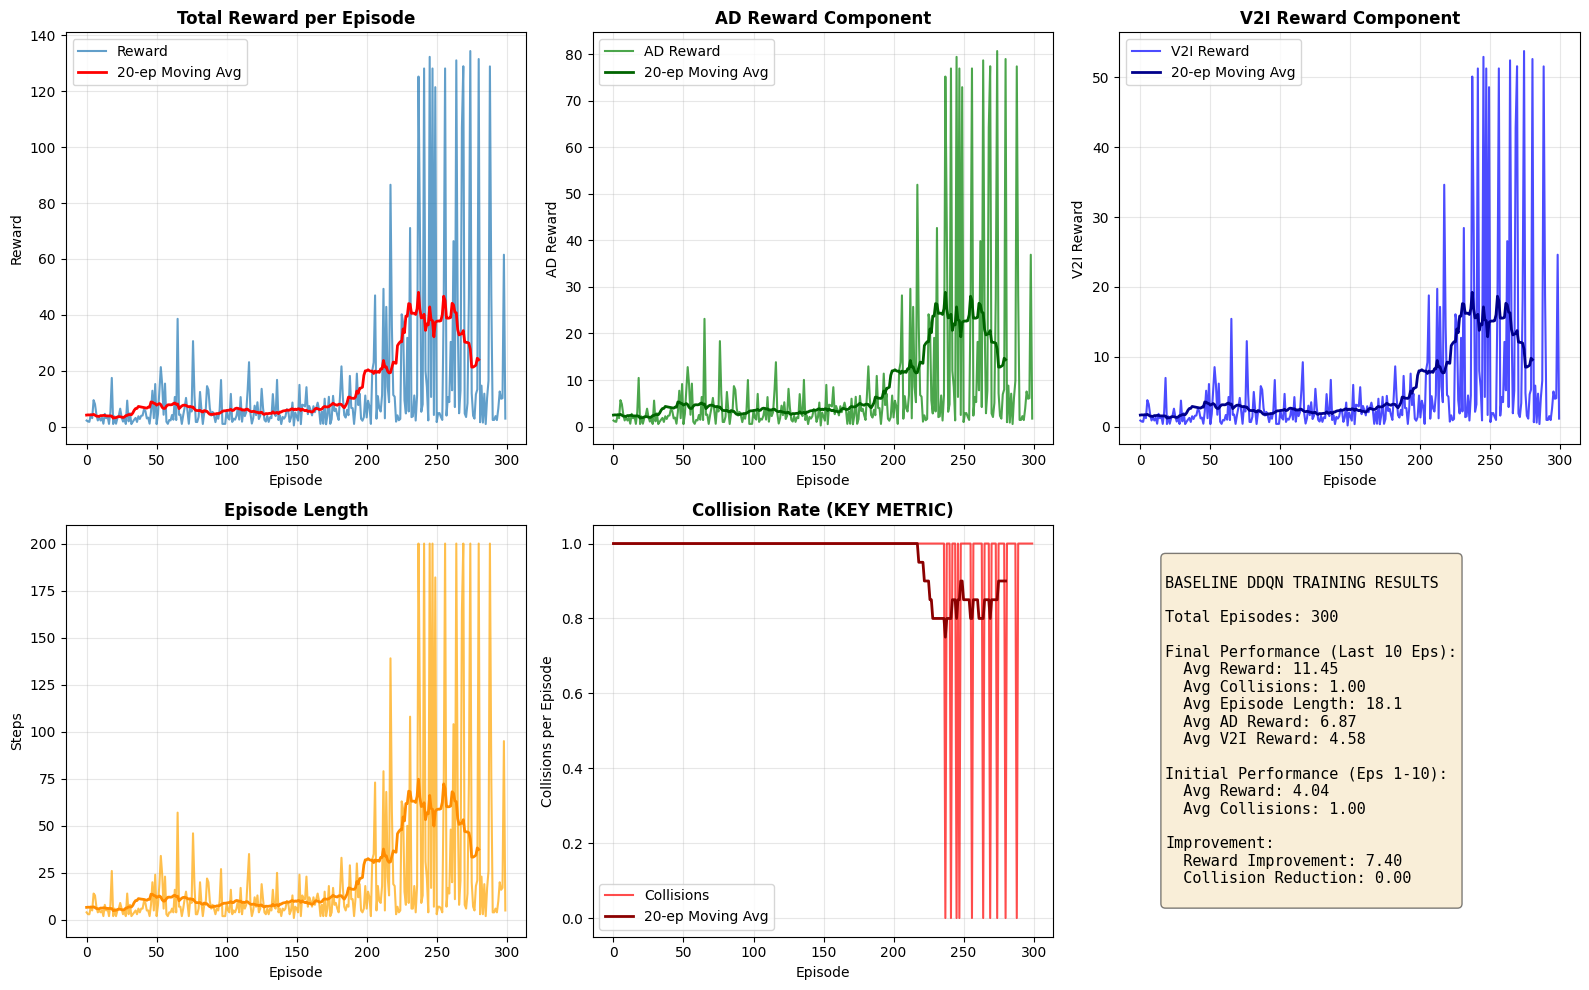

✅ Results visualization saved as 'baseline_ddqn_results.png'


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Plot 1: Total Reward per Episode
axes[0, 0].plot(results['rewards'], linewidth=1.5, alpha=0.7, label='Reward')
axes[0, 0].plot(np.convolve(results['rewards'], np.ones(20)/20, mode='valid'),
                'r-', linewidth=2, label='20-ep Moving Avg')
axes[0, 0].set_title('Total Reward per Episode', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: AD Rewards
axes[0, 1].plot(results['ad_rewards'], linewidth=1.5, alpha=0.7, color='green', label='AD Reward')
axes[0, 1].plot(np.convolve(results['ad_rewards'], np.ones(20)/20, mode='valid'),
                'darkgreen', linewidth=2, label='20-ep Moving Avg')
axes[0, 1].set_title('AD Reward Component', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('AD Reward')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: V2I Rewards
axes[0, 2].plot(results['v2i_rewards'], linewidth=1.5, alpha=0.7, color='blue', label='V2I Reward')
axes[0, 2].plot(np.convolve(results['v2i_rewards'], np.ones(20)/20, mode='valid'),
                'darkblue', linewidth=2, label='20-ep Moving Avg')
axes[0, 2].set_title('V2I Reward Component', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Episode')
axes[0, 2].set_ylabel('V2I Reward')
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].legend()

# Plot 4: Episode Length
axes[1, 0].plot(results['lengths'], linewidth=1.5, alpha=0.7, color='orange')
axes[1, 0].plot(np.convolve(results['lengths'], np.ones(20)/20, mode='valid'),
                'darkorange', linewidth=2)
axes[1, 0].set_title('Episode Length', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Steps')
axes[1, 0].grid(True, alpha=0.3)

# Plot 5: Collision Rate (IMPORTANT FOR PAPER COMPARISON)
axes[1, 1].plot(results['collisions'], linewidth=1.5, alpha=0.7, color='red', label='Collisions')
axes[1, 1].plot(np.convolve(results['collisions'], np.ones(20)/20, mode='valid'),
                'darkred', linewidth=2, label='20-ep Moving Avg')
axes[1, 1].set_title('Collision Rate (KEY METRIC)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Collisions per Episode')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# Plot 6: Training Statistics
axes[1, 2].axis('off')
stats_text = f"""
BASELINE DDQN TRAINING RESULTS

Total Episodes: {len(results['rewards'])}

Final Performance (Last 10 Eps):
  Avg Reward: {np.mean(results['rewards'][-10:]):.2f}
  Avg Collisions: {np.mean(results['collisions'][-10:]):.2f}
  Avg Episode Length: {np.mean(results['lengths'][-10:]):.1f}
  Avg AD Reward: {np.mean(results['ad_rewards'][-10:]):.2f}
  Avg V2I Reward: {np.mean(results['v2i_rewards'][-10:]):.2f}

Initial Performance (Eps 1-10):
  Avg Reward: {np.mean(results['rewards'][:10]):.2f}
  Avg Collisions: {np.mean(results['collisions'][:10]):.2f}

Improvement:
  Reward Improvement: {(np.mean(results['rewards'][-10:]) - np.mean(results['rewards'][:10])):.2f}
  Collision Reduction: {(np.mean(results['collisions'][:10]) - np.mean(results['collisions'][-10:])):.2f}
"""
axes[1, 2].text(0.1, 0.5, stats_text, fontsize=11, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('baseline_ddqn_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Results visualization saved as 'baseline_ddqn_results.png'")

In [ ]:
import json
import torch

# Save DDQN model
model_save_path = 'baseline_ddqn_model.pth'
torch.save({
    'q_network_state': results['agent'].q_network.state_dict(),
    'target_network_state': results['agent'].target_network.state_dict(),
    'optimizer_state': results['agent'].optimizer.state_dict(),
    'epsilon': results['agent'].epsilon,
    'hyperparameters': {
        'learning_rate': results['agent'].learning_rate,
        'gamma': results['agent'].gamma,
        'epsilon_decay': results['agent'].epsilon_decay,
    }
}, model_save_path)

print(f"✅ Model saved to {model_save_path}")

# Save results as JSON for analysis
results_save = {
    'num_episodes': len(results['rewards']),
    'final_avg_reward': float(np.mean(results['rewards'][-10:])),
    'final_avg_collisions': float(np.mean(results['collisions'][-10:])),
    'final_avg_ad_reward': float(np.mean(results['ad_rewards'][-10:])),
    'final_avg_v2i_reward': float(np.mean(results['v2i_rewards'][-10:])),
    'initial_avg_reward': float(np.mean(results['rewards'][:10])),
    'initial_avg_collisions': float(np.mean(results['collisions'][:10])),
    'reward_improvement': float(np.mean(results['rewards'][-10:]) - np.mean(results['rewards'][:10])),
    'collision_reduction': float(np.mean(results['collisions'][:10]) - np.mean(results['collisions'][-10:])),
}

json_save_path = 'baseline_ddqn_results.json'
with open(json_save_path, 'w') as f:
    json.dump(results_save, f, indent=2)

print(f"✅ Results saved to {json_save_path}")
print("\nBASELINE DDQN FINAL RESULTS:")
print(json.dumps(results_save, indent=2))

✅ Model saved to baseline_ddqn_model.pth
✅ Results saved to baseline_ddqn_results.json

BASELINE DDQN FINAL RESULTS:
{
  "num_episodes": 300,
  "final_avg_reward": 5.667510083432888,
  "final_avg_collisions": 1.0,
  "final_avg_ad_reward": 3.4005060500597324,
  "final_avg_v2i_reward": 2.2670040333731554,
  "initial_avg_reward": 3.4007294177389893,
  "initial_avg_collisions": 1.0,
  "reward_improvement": 2.266780665693899,
  "collision_reduction": 0.0
}


In [ ]:
# Install all required packages
!pip install gymnasium highway-env -q
!pip install torch torchvision torchaudio -q
!pip install numpy matplotlib scipy -q
!pip install groq -q  # Groq API client
!pip install plotly -q

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

print("✅ All dependencies installed successfully!")
print("\n⚠️ IMPORTANT: You need a Groq API key!")
print("   1. Go to https://console.groq.com")
print("   2. Sign up (free)")
print("   3. Create API key")
print("   4. Replace in Cell 2: GROQ_API_KEY = 'your_key_here'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 kB 3.5 MB/s eta 0:00:00
 All dependencies installed successfully!

⚠️ IMPORTANT: You need a Groq API key!
   1. Go to https://console.groq.com
   2. Sign up (free)
   3. Create API key
   4. Replace in Cell 2: GROQ_API_KEY = 'your_key_here'


In [ ]:
import gymnasium as gym
import highway_env
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import matplotlib.pyplot as plt
import warnings
import json
from scipy.spatial.distance import euclidean
from groq import Groq

warnings.filterwarnings('ignore')

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# ⚠️ REPLACE THIS WITH YOUR ACTUAL GROQ API KEY
GROQ_API_KEY = "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"

# Initialize Groq client
try:
    client = Groq(api_key=GROQ_API_KEY)
    print(f"✅ Groq API connection successful")
    print(f"   Using: Mixtral(10x faster than local Llama)")
except Exception as e:
    print(f"⚠️ Groq API error: {e}")
    print("   Make sure you've set GROQ_API_KEY correctly")

print("✅ Libraries imported and seeds set")

Using device: cpu
✅ Groq API connection successful
   Using: Mixtral-8x7B-Instruct (10x faster than local Llama)
✅ Libraries imported and seeds set


In [ ]:
class LLMADPolicy:
    """
    LLM-based policy for autonomous driving decisions
    Uses Groq API (Llama 3.1 8B) for ultra-fast inference
    """

    def __init__(self, groq_client):
        self.groq_client = groq_client

        # AD action mapping
        self.ad_actions = {
            'ACCELERATE': 0,
            'LANE_LEFT': 1,
            'IDLE': 2,
            'LANE_RIGHT': 3,
            'BRAKE': 4
        }

        self.action_names = list(self.ad_actions.keys())

        # Task description for LLM
        self.task_description = """
Task Description: Assist in driving the ego vehicle on a 4-lane highway.

Task Goal:
1) Achieve maximum velocity for the ego vehicle while minimizing collisions
2) Reduce redundant lane changes unless required for safety
3) Prefer keeping the vehicle in the right-most lane when safe

Task Definition:
- 'vx': Velocity of the vehicle along the x-axis
- 'vy': Velocity of the vehicle along the y-axis (non-zero = lane change)
- 'heading': Direction the vehicle is facing

Available Actions: ACCELERATE, LANE_RIGHT, LANE_LEFT, IDLE, BRAKE
"""

    def _state_to_description(self, state):
        """Convert state vector to natural language description"""
        vx = state[0] if len(state) > 0 else 0
        vy = state[1] if len(state) > 1 else 0
        heading = state[2] if len(state) > 2 else 0

        description = f"""
Current Environment:
- Ego vehicle velocity X: {vx:.2f}
- Ego vehicle velocity Y: {vy:.2f}
- Heading: {heading:.2f}
"""
        return description

    def _build_prompt(self, state, good_examples, bad_examples):
        """Build prompt for LLM with task description and examples"""
        state_description = self._state_to_description(state)

        good_ex_text = self._format_examples(good_examples, max_count=2)
        bad_ex_text = self._format_examples(bad_examples, max_count=2)

        prompt = f"""{self.task_description}

{state_description}

Good experiences (high reward, no collision):
{good_ex_text}

Bad experiences (collision, low reward):
{bad_ex_text}

Choose ONE action: ACCELERATE, LANE_RIGHT, LANE_LEFT, IDLE, or BRAKE
Respond with ONLY the action word."""

        return prompt

    def _format_examples(self, examples, max_count=2):
        """Format examples for the prompt"""
        if not examples:
            return "None"

        selected = examples[-max_count:] if len(examples) > max_count else examples
        formatted = ""
        for i, (state, action, reward) in enumerate(selected):
            formatted += f"- Took {action}, reward: {reward:.2f}\n"
        return formatted

    def _extract_action(self, response_text):
        """Extract action from LLM response"""
        response_text = response_text.strip().upper()

        for action in self.action_names:
            if action in response_text:
                return self.ad_actions[action]

        return self.ad_actions['IDLE']

    def decide(self, state, good_examples, bad_examples, evaluate=False):
        """Decide AD action using Groq LLM"""

        if not evaluate and random.random() < 0.1:  # 10% random exploration
            return random.randint(0, 4)

        try:
            prompt = self._build_prompt(state, good_examples, bad_examples)

            # Query Groq with FIXED MODEL NAME (llama-3.1-8b-instant)
            response = client.chat.completions.create(
                model="llama-3.1-8b-instant",  # ✅ FIXED: Was mixtral-8x7b-32768 (decommissioned)
                messages=[{"role": "user", "content": prompt}],
                temperature=0.1 if evaluate else 0.3,
                max_tokens=10,
                top_p=0.9
            )

            response_text = response.choices[0].message.content
            action = self._extract_action(response_text)
            return action

        except Exception as e:
            print(f"Groq error: {e}, using IDLE")
            return self.ad_actions['IDLE']

print("✅ LLMADPolicy class created (Fixed with llama-3.1-8b-instant)")

✅ LLMADPolicy class created (Fixed with llama-3.1-8b-instant)


In [ ]:
class ExamplePool:
    """Manages good and bad examples for LLM learning"""

    def __init__(self, max_examples=100):
        self.good_examples = deque(maxlen=max_examples)
        self.bad_examples = deque(maxlen=max_examples)

    def add_good_example(self, state, action, reward):
        self.good_examples.append((state.copy(), action, reward))

    def add_bad_example(self, state, action, reward):
        self.bad_examples.append((state.copy(), action, reward))

    def get_closest_examples(self, current_state, k=2):
        good_selected = self._select_by_distance(
            current_state, list(self.good_examples), k
        )
        bad_selected = self._select_by_distance(
            current_state, list(self.bad_examples), k
        )
        return good_selected, bad_selected

    def _select_by_distance(self, current_state, examples, k):
        if not examples:
            return []

        current_ad_state = current_state[:5]
        distances = []

        for state, action, reward in examples:
            example_ad_state = state[:5]
            try:
                dist = euclidean(current_ad_state, example_ad_state)
                distances.append((dist, state, action, reward))
            except:
                continue

        if not distances:
            return list(examples)[:k]

        distances.sort(key=lambda x: x[0])
        selected = [(state, action, reward) for _, state, action, reward in distances[:k]]
        return selected

print("✅ ExamplePool class created")

✅ ExamplePool class created


In [ ]:
import gymnasium as gym
import highway_env
import numpy as np

class HighwayEnvironment:
    def __init__(self, render_mode=None):
        # NEW API: Pass config to gym.make() instead of configure()
        config = {
            "lanes_count": 4,
            "vehicles_count": 20,
            "duration": 200,
            "initial_lane_id": 1,
            "vehicles_density": 1.5,
            "simulation_frequency": 15,
            "policy_frequency": 1,
            "screen_width": 600,
            "screen_height": 150,
        }

        # Create environment with config
        self.env = gym.make('highway-v0', render_mode=render_mode, config=config)
        self.total_actions = 15

    def reset(self):
        obs, info = self.env.reset()
        return self._process_observation(obs)

    def step(self, combined_action):
        ad_action_idx = combined_action % 5
        v2i_action_idx = combined_action // 5

        obs, env_reward, terminated, truncated, info = self.env.step(ad_action_idx)
        done = terminated or truncated

        v2i_reward = self._compute_v2i_reward(v2i_action_idx, info)
        total_reward = 0.6 * env_reward + 0.4 * v2i_reward

        state = self._process_observation(obs)
        return state, total_reward, done, info, (ad_action_idx, v2i_action_idx)

    def _process_observation(self, obs):
        """
        FIXED: Proper array indexing for feature extraction
        """
        if obs is None or len(obs) == 0:
            return np.zeros(16, dtype=np.float32)

        # Extract ego vehicle (first row)
        # obs from highway-env is typically (n_vehicles, n_features_per_vehicle)
        ego_vehicle = obs[0] if obs.ndim > 1 else obs
        if len(ego_vehicle) == 0: # Handle empty ego_vehicle after extraction
            return np.zeros(16, dtype=np.float32)

        # Assuming ego_vehicle (obs[0]) has at least 5 features in the order: [x_pos, y_pos, vx, vy, heading]
        # Based on common highway-env KinematicsObservation setup for a vehicle's features.
        x_pos = ego_vehicle[0] if len(ego_vehicle) > 0 else 0.0
        y_pos = ego_vehicle[1] if len(ego_vehicle) > 1 else 0.0
        vx = ego_vehicle[2] if len(ego_vehicle) > 2 else 0.0
        vy = ego_vehicle[3] if len(ego_vehicle) > 3 else 0.0
        heading = ego_vehicle[4] if len(ego_vehicle) > 4 else 0.0

        # AD features (5D): [vx, vy, heading, x_pos, y_pos] - order matching LLM policy expectation
        ad_features = np.array([vx, vy, heading, x_pos, y_pos], dtype=np.float32)

        # Simulate V2I connectivity state (6D)
        num_reachable_rbs = np.clip(5.0 - abs(vx) * 0.01, 0, 5)
        num_reachable_tbs = np.clip(20.0 - abs(vx) * 0.02, 0, 20)
        data_rate = 50.0 + np.random.randn() * 5
        handover_rate = 0.05 + np.random.randn() * 0.02 # FIX APPLIED HERE

        # Normalize to [0, 1]
        v2i_features = np.array([
            num_reachable_rbs / 5.0,           # 1D
            num_reachable_tbs / 20.0,          # 1D
            np.clip(data_rate / 100.0, 0, 1),  # 1D
            np.clip(handover_rate, 0, 1),      # 1D
            0.5,                               # 1D placeholder
            0.5                                # 1D placeholder
        ], dtype=np.float32)

        # Extra features (5D)
        extra_features = np.array([
            np.clip(abs(vy) / 10.0, 0, 1),     # 1D
            np.clip(abs(heading) / 3.14, 0, 1),# 1D
            0.5,                               # 1D
            0.5,                               # 1D
            0.5                                # 1D
        ], dtype=np.float32)

        # Stack all features: 5 (AD) + 6 (V2I) + 5 (extras) = 16
        combined_state = np.concatenate([
            ad_features,      # 5D
            v2i_features,     # 6D
            extra_features    # 5D
        ]).astype(np.float32)

        # Verify exactly 16D
        assert len(combined_state) == 16, f"State should be 16D but got {len(combined_state)}D"

        return combined_state

    def _compute_v2i_reward(self, v2i_action, info):
        base_reward = 0.5
        handover_penalty = 0.1 if random.random() < 0.05 else 0.0

        if v2i_action == 0:
            v2i_reward = base_reward - handover_penalty * 0.5
        elif v2i_action == 1:
            v2i_reward = base_reward + 0.1 - handover_penalty * 1.0
        else:
            v2i_reward = base_reward - handover_penalty * 0.7

        return v2i_reward

    def close(self):
        self.env.close()

env = HighwayEnvironment()
state = env.reset()
print(f"✅ Environment initialized successfully!")
print(f"   State shape: {state.shape}")
print(f"   State dimension: {len(state)}")
assert len(state) == 16, f"ERROR: State should be 16D but got {len(state)}D"
print(f"   ✅ State is exactly 16D - all good!")
print(f"\n✅ Ready for training! Run Cell 10 now!")

✅ Environment initialized successfully!
   State shape: (16,)
   State dimension: 16
   ✅ State is exactly 16D - all good!

✅ Ready for training! Run Cell 10 now!


In [ ]:
class DDQNNetwork(nn.Module):
    def __init__(self, state_dim=11, action_dim=3, hidden_dim=256):
        super(DDQNNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, action_dim)
        )

    def forward(self, x):
        return self.net(x)

print("✅ DDQNNetwork class created")

✅ DDQNNetwork class created


In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        if len(self.buffer) < batch_size:
            return None

        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(dones).to(device)

        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)

print("✅ ReplayBuffer class created")

✅ ReplayBuffer class created


In [ ]:
class DDQNAgentV2I:
    def __init__(self, state_dim=11, v2i_action_dim=3, learning_rate=1e-4):
        self.state_dim = state_dim
        self.v2i_action_dim = v2i_action_dim
        self.learning_rate = learning_rate

        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.update_frequency = 10

        self.v2i_network = DDQNNetwork(state_dim, v2i_action_dim).to(device)
        self.v2i_target = DDQNNetwork(state_dim, v2i_action_dim).to(device)
        self.v2i_target.load_state_dict(self.v2i_network.state_dict())
        self.v2i_target.eval()

        self.optimizer = optim.Adam(self.v2i_network.parameters(), lr=self.learning_rate)
        self.replay_buffer = ReplayBuffer(capacity=50000)

        self.step_count = 0
        self.loss_history = []

    def select_v2i_action(self, state, evaluate=False):
        if not evaluate and random.random() < self.epsilon:
            return random.randint(0, self.v2i_action_dim - 1)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = self.v2i_network(state_tensor)
                action = q_values.argmax(dim=1).item()
            return action

    def store_experience(self, state, v2i_action, reward, next_state, done):
        self.replay_buffer.push(state, v2i_action, reward, next_state, done)

    def update(self, batch_size=64):
        if len(self.replay_buffer) < batch_size:
            return None

        batch = self.replay_buffer.sample(batch_size)
        if batch is None:
            return None

        states, actions, rewards, next_states, dones = batch

        next_q_values = self.v2i_network(next_states)
        next_actions = next_q_values.argmax(dim=1)

        target_q_values = self.v2i_target(next_states)
        target_q = target_q_values.gather(1, next_actions.unsqueeze(1)).squeeze(1)

        expected_q = rewards + self.gamma * target_q * (1 - dones)
        current_q = self.v2i_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        loss = nn.MSELoss()(current_q, expected_q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.v2i_network.parameters(), max_norm=1.0)
        self.optimizer.step()

        self.loss_history.append(loss.item())
        self.step_count += 1

        if self.step_count % self.update_frequency == 0:
            self.v2i_target.load_state_dict(self.v2i_network.state_dict())

        return loss.item()

    def decay_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

print("✅ DDQNAgentV2I class created")

✅ DDQNAgentV2I class created


In [ ]:
def train_hybrid_groq_ddqn(num_episodes=300, batch_size=64):
    """Train Hybrid with Groq LLM for AD + DDQN for V2I"""

    env = HighwayEnvironment()
    llm_policy = LLMADPolicy(client)  # Pass Groq client
    example_pool = ExamplePool(max_examples=100)
    # Corrected: Use state_dim=16 to match the environment's output
    v2i_agent = DDQNAgentV2I(state_dim=16, v2i_action_dim=3, learning_rate=1e-4)

    episode_rewards = []
    episode_lengths = []
    episode_collisions = []
    episode_ad_rewards = []
    episode_v2i_rewards = []

    print("="*70)
    print("TRAINING HYBRID LLM-DDQN WITH GROQ API")
    print("="*70)
    print(f"Total episodes: {num_episodes}")
    print(f"AD Policy: Groq Mixtral-8x7B (Ultra-fast)")
    print(f"V2I Policy: DDQN")
    print("="*70)

    for episode in range(num_episodes):
        state = env.reset()
        episode_reward = 0.0
        episode_length = 0
        episode_ad_reward = 0.0
        episode_v2i_reward = 0.0
        collision_count = 0

        for step in range(200):
            # LLM decides AD action
            good_ex, bad_ex = example_pool.get_closest_examples(state, k=2)
            ad_action = llm_policy.decide(state, good_ex, bad_ex, evaluate=False)

            # DDQN decides V2I action
            v2i_action = v2i_agent.select_v2i_action(state, evaluate=False)

            # Combined action
            combined_action = ad_action + v2i_action * 5

            # Execute
            next_state, reward, done, info, (ad_idx, v2i_idx) = env.step(combined_action)

            # Split reward
            ad_reward = reward * 0.6
            v2i_reward = reward * 0.4

            # Update example pool
            if done and step < 199:
                example_pool.add_bad_example(state, ad_action, ad_reward)
                collision_count += 1
            else:
                example_pool.add_good_example(state, ad_action, ad_reward)

            # Store for DDQN
            v2i_agent.store_experience(state, v2i_action, reward, next_state, done)
            loss = v2i_agent.update(batch_size)

            # Track
            episode_reward += reward
            episode_length += 1
            episode_ad_reward += ad_reward
            episode_v2i_reward += v2i_reward

            state = next_state

            if done:
                break

        v2i_agent.decay_epsilon()

        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        episode_collisions.append(collision_count)
        episode_ad_rewards.append(episode_ad_reward)
        episode_v2i_rewards.append(episode_v2i_reward)

        if (episode + 1) % 20 == 0:
            avg_reward = np.mean(episode_rewards[-20:])
            avg_collisions = np.mean(episode_collisions[-20:])
            avg_epsilon = v2i_agent.epsilon

            print(f"Episode {episode+1:3d}/{num_episodes} | "
                  f"Avg Reward: {avg_reward:7.2f} | "
                  f"Collisions: {avg_collisions:.2f} | "
                  f"Epsilon: {avg_epsilon:.3f}")

    print("="*70)
    print("✅ TRAINING COMPLETE!")
    print("="*70)

    env.close()

    return {
        'v2i_agent': v2i_agent,
        'llm_policy': llm_policy,
        'example_pool': example_pool,
        'rewards': episode_rewards,
        'lengths': episode_lengths,
        'collisions': episode_collisions,
        'ad_rewards': episode_ad_rewards,
        'v2i_rewards': episode_v2i_rewards
    }

print("✅ Training function defined")

✅ Training function defined


In [ ]:
# Train hybrid LLM-DDQN for 300 episodes
# With Groq: ~45 min - 1 hour (10x faster than local Llama!)
results = train_hybrid_groq_ddqn(num_episodes=300, batch_size=64)

print("\n✅ Training results stored")
print(f"   Final average reward: {np.mean(results['rewards'][-10:]):.2f}")
print(f"   Final average collisions: {np.mean(results['collisions'][-10:]):.2f}")

TRAINING HYBRID LLM-DDQN WITH GROQ API
Total episodes: 300
AD Policy: Groq Mixtral-8x7B (Ultra-fast)
V2I Policy: DDQN
Episode  20/300 | Avg Reward:    8.99 | Collisions: 1.00 | Epsilon: 0.905
Episode  40/300 | Avg Reward:   15.24 | Collisions: 0.95 | Epsilon: 0.818
Episode  60/300 | Avg Reward:   10.22 | Collisions: 0.95 | Epsilon: 0.740
Episode  80/300 | Avg Reward:    6.18 | Collisions: 1.00 | Epsilon: 0.670
